In [ ]:
pip install anndata

In [ ]:
pip install scanpy

In [ ]:
pip install igraph

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/ya.yaghooti@gmail.com')

In [ ]:
adata = sc.read('/ya.yaghooti@gmail.com/MyDrive/F1L_compbio_internship/outs/240701_kinker_anndata.h5ad')

In [ ]:
#identify mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
#identify ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
#identify hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

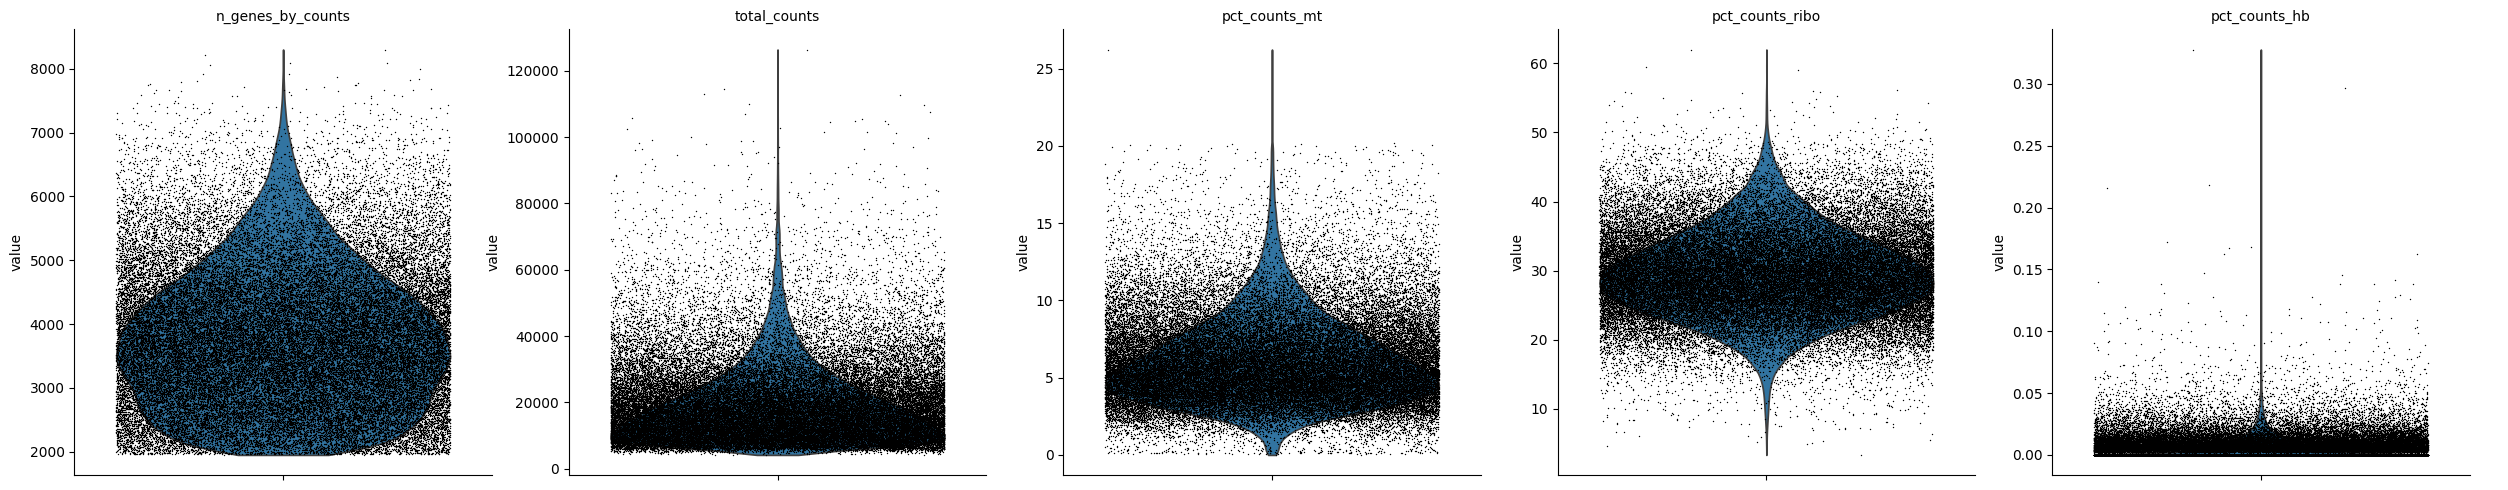

In [ ]:
sc.pl.violin(adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
             multi_panel=True,
             jitter=0.4)

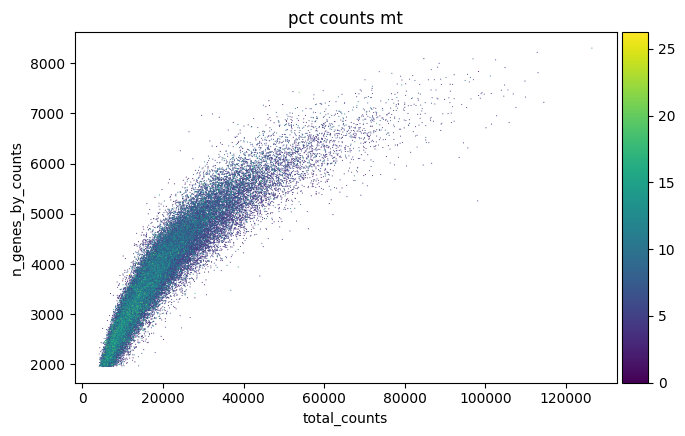

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
from scipy.stats import median_abs_deviation

In [ ]:
#define function to detect outliers using median absolute deviation (cells higher than n_mad or lower than n_mad deviations are outliers)
def is_outlier(adata, metric:str, n_mad:int):
  m = adata.obs[metric]
  is_outlier = (m < np.median(m) - n_mad * median_abs_deviation(m)) | (m > np.median(m) + n_mad * median_abs_deviation(m))
  return is_outlier

In [ ]:
#detect outlier cells based on percent mitochondrial gene counts
adata.obs["mt_outlier"] = is_outlier(adata, metric="pct_counts_mt", n_mad=3)

In [ ]:
adata.obs.mt_outlier.value_counts()

,count
mt_outlier,
False,49707
True,3806


In [ ]:
#filter outlier cells
adata = adata[~adata.obs.mt_outlier]

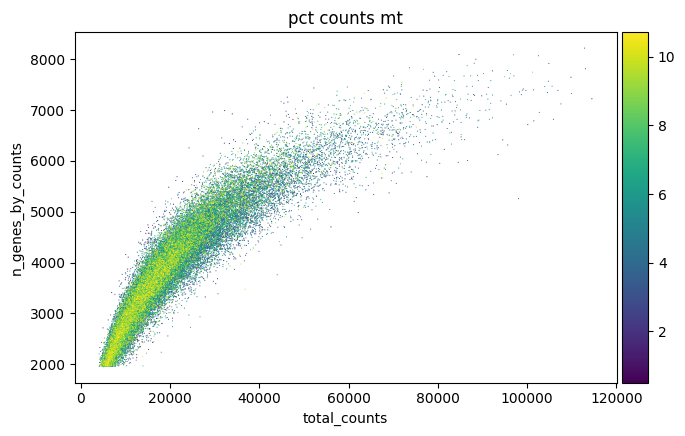

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
#run when TPU is available
#sc.pp.scrublet(adata)

In [ ]:
#save counts
adata.layers["counts"] = adata.X.copy()

In [ ]:
#normalization
sc.pp.normalize_total(adata, target_sum=1e4)
#scaling
sc.pp.log1p(adata)
#feature selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat")

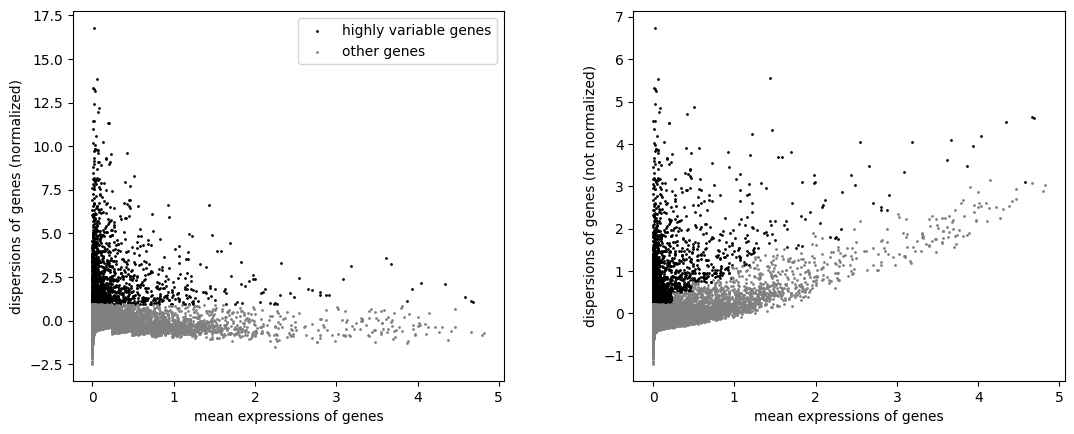

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
#dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack')

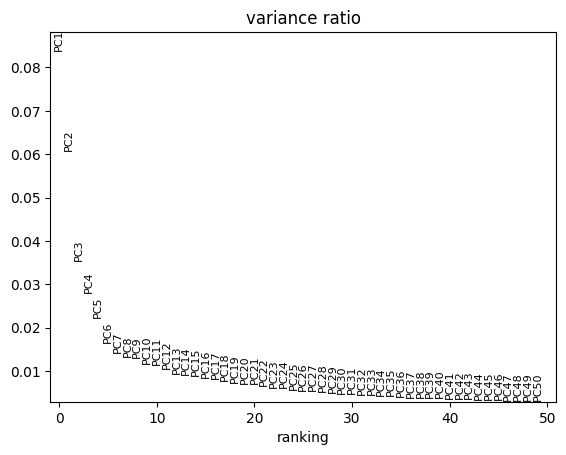

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

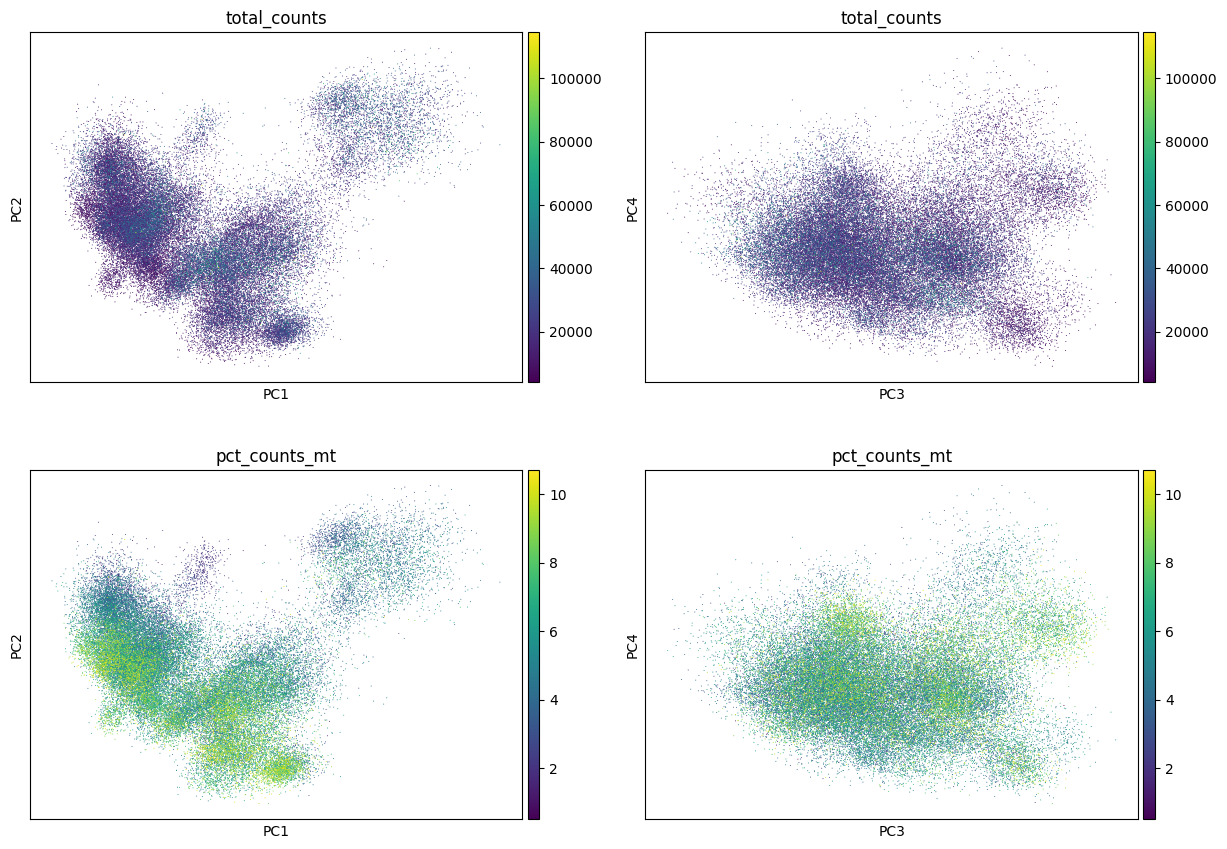

In [ ]:
sc.pl.pca(
    adata,
    color=["total_counts", "total_counts", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=20)
sc.tl.umap(adata, random_state=20)

In [ ]:
pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.4 MB/s eta 0:00:00


In [ ]:
sc.tl.leiden(adata, random_state=20)

<ipython-input-28-c31e96f8f30b>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, random_state=20)


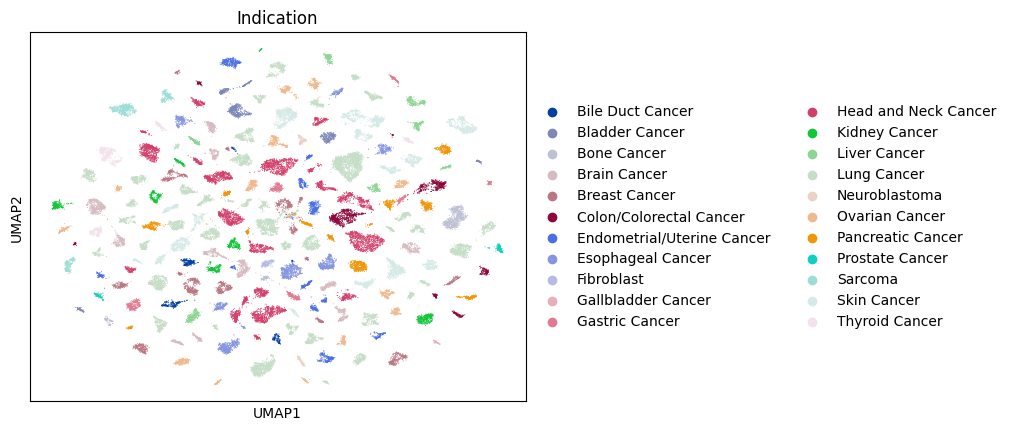

In [ ]:
sc.pl.umap(
    adata,
    color="Indication",
    size=2
)

In [ ]:
#The figure above is not the same as figure 1B in the paper, since this is not a t-SNE visualization, but rather a UMAP.
#However, I'm not sure how many PCs the authors used to produce the figure.

In [ ]:
sc.tl.tsne(adata, n_pcs=50, random_state=20)

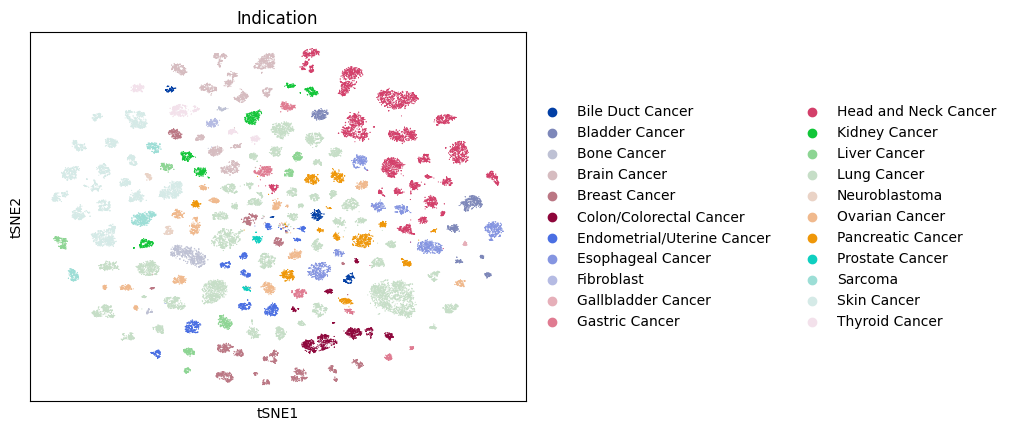

In [ ]:
sc.pl.tsne(
    adata,
    color="Indication",

)

In [ ]:
#Inconsistently assigned cells were probably deleted
adata[adata.obs["CellLine"]=="NCIH1048"]

View of AnnData object with n_obs × n_vars = 0 × 22939
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mt_outlier', 'n_counts', 'leiden'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p

In [ ]:
#Recreating figure 1B in the paper
adata_filtered = adata[adata.obs["CellLine"].isin(["NCIH1048_LUNG", "NCIH1568_LUNG", "NCIH1792_LUNG", "NCIH1944_LUNG", "NCIH2077_LUNG", "NCIH2087_LUNG", "NCIH358_LUNG", "NCIH727_LUNG",
                                                   "EFM192A_BREAST", "HCC1419_BREAST", "KPL1_BREAST", "ZR751_BREAST",
                                                   "PANC0203_PANCREAS", "PK45H_PANCREAS", "SW1990_PANCREAS",
                                                   "HYSE520_OESOPHAGUS", "TE6_OESOPHAGUS",
                                                   "HS729_SOFT_TISSUE	", "RD_SOFT_TISSUE	",
                                                   "CL34_LARGE_INTESTINE", "HEC59_ENDOMETRIUM", "KMRC3_KIDNEY", "SNU423_UPPER_AERODIGESTIVE_TRACT", "MKN7_STOMACH"])]

sc.tl.tsne(adata_filtered, n_pcs=50, random_state=20)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_tsne.py:168: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm["X_tsne"] = X_tsne  # annotate samples with tSNE coordinates


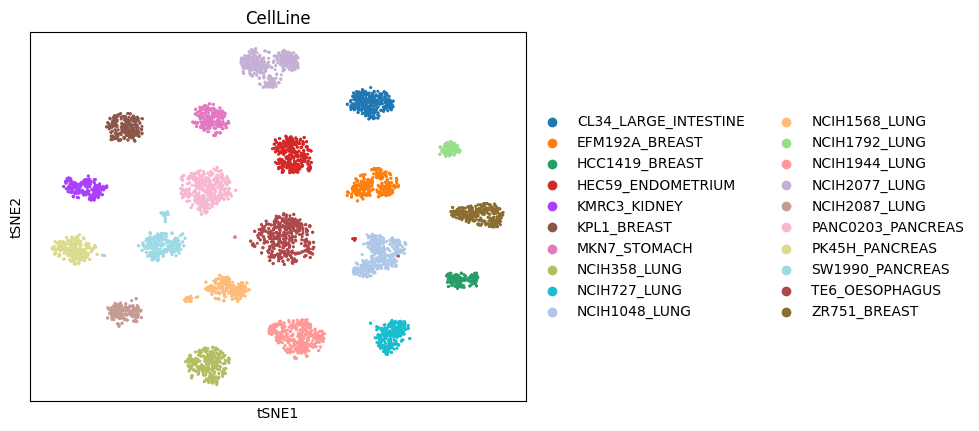

In [ ]:
sc.pl.tsne(
    adata_filtered,
    color="CellLine"

)

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_tsne.py:168: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm["X_tsne"] = X_tsne  # annotate samples with tSNE coordinates
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_tsne.py:168: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm["X_tsne"] = X_tsne  # annotate samples with tSNE coordinates
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_tsne.py:168: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm["X_tsne"] = X_tsne  # annotate samples with tSNE coordinates


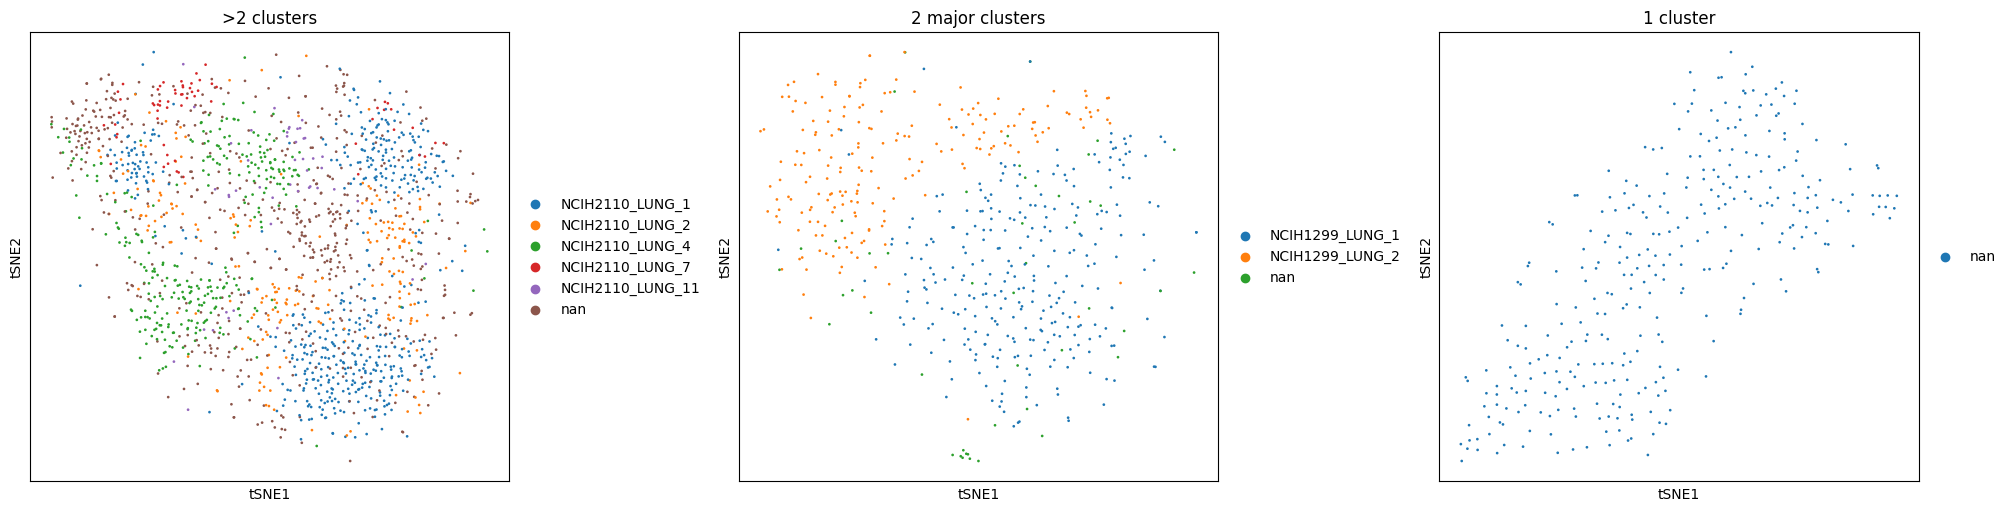

In [ ]:
#REcreating figure 2B in the paper

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout="constrained")
cell_lines =["NCIH2110", "NCIH1299", "JHU006"]

NCIH2110 = adata[adata.obs["CellLine"].str.contains(cell_lines[0])]
sc.tl.tsne(NCIH2110, n_pcs=50, random_state=20)
sc.pl.tsne(
    NCIH2110,
    color="Discrete_cluster_minpts5_eps1.2",
    ax=axs[0],
    size=15,
    title=">2 clusters",
    wspace=2,
    hspace=2,
    show=False
)

NCIH1299 = adata[adata.obs["CellLine"].str.contains(cell_lines[1])]
sc.tl.tsne(NCIH1299, n_pcs=50, random_state=20)
sc.pl.tsne(
    NCIH1299,
    color="Discrete_cluster_minpts5_eps1.2",
    ax=axs[1],
    size=15,
    title="2 major clusters",
    wspace=2,
    hspace=2,
    show=False
)
#Cell line not found in the data!
#sc.pl.tsne(
#    adata[adata.obs["CellLine"].str.contains("CAK12")],
#    color="Discrete_cluster_minpts5_eps1.2",
#    ax=axs[2],

#    show=False
#)

JHU006 = adata[adata.obs["CellLine"].str.contains(cell_lines[2])]
sc.tl.tsne(JHU006, n_pcs=50, random_state=20)

sc.pl.tsne(
    JHU006,
    color="Discrete_cluster_minpts5_eps1.2",
    ax=axs[2],
    size=15,
    title="1 cluster",
    wspace=2,
    hspace=2,
    show=False
)
plt.show()


<ipython-input-47-8224f46ea7ef>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  filtered_adata.obs["cells"] = [i for i in range(len(filtered_adata.obs))]


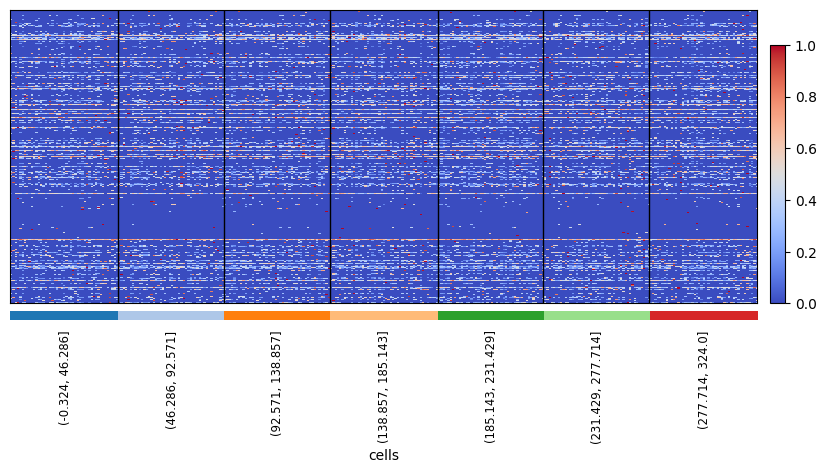

In [ ]:
#Trying to recreate figure 2D but this heatmap doesn't look anything like the figure in the paper.
#Perhaps would be able to do it in R since the authors' created the figures using R

filtered_adata = adata[adata.obs["CellLine"].str.contains("JHU006")]
filtered_adata.obs["cells"] = [i for i in range(len(filtered_adata.obs))]

sc.pl.heatmap(
    filtered_adata,
    use_raw=False,
    var_names= adata.var_names,
    groupby="cells",
    swap_axes=True,
    standard_scale="var",
    cmap="coolwarm"

)

In [ ]:
adata.write("/ya.yaghooti@gmail.com/MyDrive/F1L_compbio_internship/outs/240701_kinker_anndata_preprocessed.h5ad")